
# SVM model with detailed results & possibility for grid search. 
Using the extracted features from create_features_from_PC-GITA.py to predict. 
- Provides the same results as SVM_model, but with more detail investigation of the results. 

# Imports

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.model_selection import TunedThresholdClassifierCV, cross_validate, PredefinedSplit



from functions import *
from definition_of_data_and_feature_groups import *
from constants import *


# Setup for the experiment 

### Things to choose: 

In [2]:
###########################################

# Seed number 
seed_number = 42
np.random.seed(seed_number) 

# Features 
features_for_model = ZOF # phonation_all_features # [] or [articulation_all_features + phonation_all_features + prosody_all_features]

# Utterances 
utterance_type =  GITA_cont_speech # [""] # [""] # ["Vowels", "modulated_vowels"] or etc. 
specific_utterance = [""] # ["a1", "viaje"] or etc. 

feature_sheet_name = "GITA-all" # "GITA-all" # "EWA-100" # EWA-balanced-69 # Sheet name we want to get features from. 
fold_file = "kfold-groups-tsv.csv"

# SVM parameters --> CHosen based on grid search from model_and_feature_eval
kernel_best ='rbf' 
C_best = 100
gamma_best = 0.0001

###########################################

# Data processing 
- Get features, metadata and fold info
- Change all ID columns to be on the same form as fold info --> Like: "ID" and "A0013 or AC0013"
- Add metadata columns to feature info 
- Restructure the data.

In [3]:

feature_path = personal_path_to_code + '/Features.xlsx'   # Defines path to feature folder to use. 
features = pd.read_excel(feature_path, sheet_name=feature_sheet_name, index_col=0)

metadata_path = os.path.join(personal_path_to_PC_GITA,'PCGITA_metadata.xlsx')
metadata = pd.read_excel(metadata_path)

fold_info_path = os.path.join(personal_path_to_balanced_folds, fold_file) # File where we have the fold distribution saved. 
fold_info = pd.read_csv(fold_info_path)

metadata = restructure_id(metadata)

metadata_columns =  ["SEX", "AGE", "UPDRS", "UPDRS-speech", "H/Y", "time after diagnosis"] # Use this as definition on what to remove later on. 
fold_info_columns = ["Fold"]
feature_info_columns = ["ID", "Utterance", "Utterance type", "Group"]

# patient_info_columns will be used later on to remove all metadata and then also want to remove id. 
patient_info_columns = feature_info_columns + metadata_columns + fold_info_columns

# Add metadata and fold info: 
features = add_columns_to_dataframe(features, metadata, metadata_columns)
features = add_columns_to_dataframe(features, fold_info, fold_info_columns)


# Sorting out the data and features we want to use: 
if utterance_type != [""]: # If defined utterance sub groups (like vowels or words or combinations)
        features = features[features["Utterance type"].isin(utterance_type)]

if specific_utterance != [""]: # If defined specific utterances (like "a" or "viaje" or combinations)
        features = features[features["Utterance"].isin(specific_utterance)]

if features_for_model:
        # print("Features choosen: ", features_for_model)
        features = features.loc[:, features_for_model + patient_info_columns]
        
# Remove NaN
features = remove_NaN(features, patient_info_columns, print_out = False)

# SVM 

## Defining a SVM model [Based on best grid search values]

In [4]:
svm_model = SVC(kernel=kernel_best, C=C_best, gamma = gamma_best) 

# Cross validation: 

In [5]:
def print_out_fold_info(data):
    """
    Prints out fold information from DataFrame containing features, metadata and the fold distribution. 
    """
    num_folds = len(data["Fold"].unique())
    
    for fold_num in range(num_folds): # Iterate through folds 
        print(" ")
        fold_data = data[data['Fold'] == fold_num]
                        
        female = len(fold_data[fold_data['SEX'] == "F"])
        male = len(fold_data[fold_data['SEX'] == "M"])
        pd = len(fold_data[fold_data['Group'] == class_labels["PD"]])
        hc = len(fold_data[fold_data['Group'] == class_labels["HC"]])
        print(f"In fold number {fold_num} there are: ")
        print(f"{female} females, {male} males, {pd} with PD and {hc} from the HC group.")
        
        # Mixed group (is not the same in each fold, but interesting to know how many.)
        print("Females in HC", len(fold_data[(fold_data['SEX'] == "F") & (fold_data['Group'] == class_labels["HC"])]), "// Males in HC: ", len(fold_data[(fold_data['SEX'] == "M") & (fold_data['Group'] == class_labels["HC"])]))
        print("Females in PD: ", len(fold_data[(fold_data['SEX'] == "F") & (fold_data['Group'] == class_labels["PD"])]), "// Males in PD: ", len(fold_data[(fold_data['SEX'] == "M") & (fold_data['Group'] == class_labels["PD"])]) )


print_out_fold_info(data=features) # This shows some changes over different folds due to the lack of the 4 words. 


 
In fold number 0 there are: 
60 females, 60 males, 60 with PD and 60 from the HC group.
Females in HC 24 // Males in HC:  36
Females in PD:  36 // Males in PD:  24
 
In fold number 1 there are: 
60 females, 60 males, 60 with PD and 60 from the HC group.
Females in HC 36 // Males in HC:  24
Females in PD:  24 // Males in PD:  36
 
In fold number 2 there are: 
60 females, 60 males, 60 with PD and 60 from the HC group.
Females in HC 24 // Males in HC:  36
Females in PD:  36 // Males in PD:  24
 
In fold number 3 there are: 
60 females, 60 males, 60 with PD and 60 from the HC group.
Females in HC 36 // Males in HC:  24
Females in PD:  24 // Males in PD:  36
 
In fold number 4 there are: 
60 females, 60 males, 60 with PD and 60 from the HC group.
Females in HC 24 // Males in HC:  36
Females in PD:  36 // Males in PD:  24
 
In fold number 5 there are: 
60 females, 60 males, 60 with PD and 60 from the HC group.
Females in HC 36 // Males in HC:  24
Females in PD:  24 // Males in PD:  36
 
In

Cross validation progress:  10%|█         | 1/10 [00:00<00:01,  6.74it/s]

 
This is data for fold number 0: 
Fold Test Accuracy: 71.67%
Confusion Matrix:
[[41 19]
 [15 45]]
 
This is data for fold number 1: 


Cross validation progress:  30%|███       | 3/10 [00:00<00:01,  6.95it/s]

Fold Test Accuracy: 75.83%
Confusion Matrix:
[[51  9]
 [20 40]]
 
This is data for fold number 2: 
Fold Test Accuracy: 69.17%
Confusion Matrix:
[[51  9]
 [28 32]]
 
This is data for fold number 3: 


Cross validation progress:  50%|█████     | 5/10 [00:00<00:00,  6.94it/s]

Fold Test Accuracy: 74.17%
Confusion Matrix:
[[44 16]
 [15 45]]
 
This is data for fold number 4: 
Fold Test Accuracy: 74.17%
Confusion Matrix:
[[54  6]
 [25 35]]
 
This is data for fold number 5: 


Cross validation progress:  70%|███████   | 7/10 [00:01<00:00,  6.97it/s]

Fold Test Accuracy: 74.17%
Confusion Matrix:
[[37 23]
 [ 8 52]]
 
This is data for fold number 6: 
Fold Test Accuracy: 75.83%
Confusion Matrix:
[[46 14]
 [15 45]]
 
This is data for fold number 7: 


Cross validation progress:  90%|█████████ | 9/10 [00:01<00:00,  7.12it/s]

Fold Test Accuracy: 73.33%
Confusion Matrix:
[[39 21]
 [11 49]]
 
This is data for fold number 8: 
Fold Test Accuracy: 85.00%
Confusion Matrix:
[[50 10]
 [ 8 52]]
 
This is data for fold number 9: 


Cross validation progress: 100%|██████████| 10/10 [00:01<00:00,  7.05it/s]


Fold Test Accuracy: 79.17%
Confusion Matrix:
[[42 18]
 [ 7 53]]
Results over all 10 folds:
 
Accuracy over all 10 folds: [71.67, 75.83, 69.17, 74.17, 74.17, 74.17, 75.83, 73.33, 85.0, 79.17]
Average Accuracy: 75.2 ± 4.1%
The accuracy is variating between 69.17% and 85.0%
 
Training accuracy over all 10 folds: [88.7, 89.63, 89.17, 89.54, 88.7, 88.89, 89.35, 90.65, 88.06, 89.07]
Average Training Accuracy: 89.2 ± 0.7%
The Training accuracy is variating between 88.06% and 90.65%
 
Sensitivity over all 10 folds: [75.0, 66.67, 53.33, 75.0, 58.33, 86.67, 75.0, 81.67, 86.67, 88.33]
Average Sensitivity: 74.7 ± 11.4%
The Sensitivity is variating between 53.33% and 88.33%
 
Specificity over all 10 folds: [68.33, 85.0, 85.0, 73.33, 90.0, 61.67, 76.67, 65.0, 83.33, 70.0]
Average Specificity: 75.8 ± 9.2%
The Specificity is variating between 61.67% and 90.0%
Sum of conf matrixes:
[[455 145]
 [152 448]]


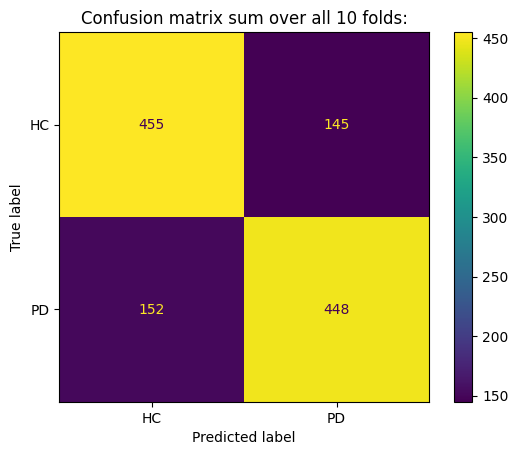

In [6]:

# 10 fold cross val for the best chooise of parameters:
accuracy_scores, training_accuracy_scores, sensitivity_scores, specificity_scores, confusion_mat_sum, metadata_with_classification_result = balanced_cross_validation(data=features, model=svm_model, metadata_columns=patient_info_columns, write_out_each_fold=True)

write_out_cross_fold_results(10, accuracy_scores, training_accuracy_scores, sensitivity_scores, specificity_scores, confusion_mat_sum)


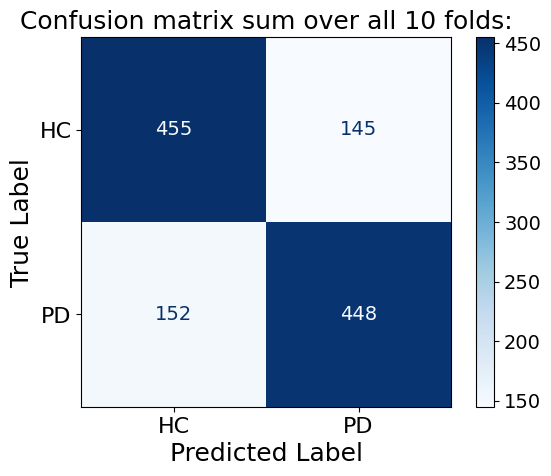

In [7]:
# Creating a prettier and more readable conf matrix: 
disp = ConfusionMatrixDisplay.from_predictions(metadata_with_classification_result["True class"], metadata_with_classification_result["Predicted Class"], display_labels=list(class_labels.keys()), cmap="Blues")
disp.ax_.set_title(f"Confusion matrix sum over all 10 folds:", fontsize=18)

# Increase the sizes of the x and y axis labels
disp.ax_.set_xlabel('Predicted Label', fontsize=18)
disp.ax_.set_ylabel('True Label', fontsize=18)

# Increase the sizes of the x and y ticks
disp.ax_.tick_params(axis='both', which='major', labelsize=16)

# Increase the size of the text in the confusion matrix cells
for text in disp.text_.ravel():
    text.set_fontsize(14)

# Show the color bar and increase the size of the color bar labels
cbar = disp.im_.colorbar
cbar.ax.tick_params(labelsize=14)

## Results over the different folds: 

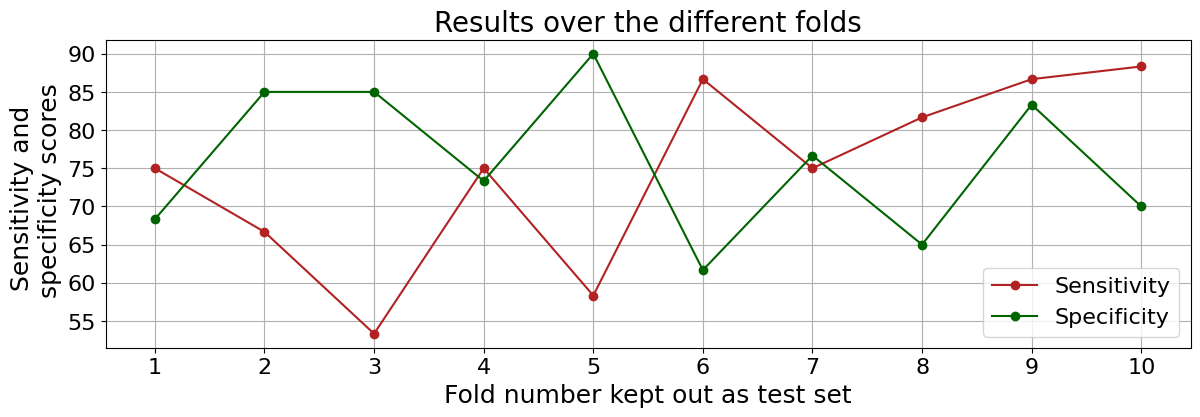

In [8]:
folds = np.arange(1, 11)
plt.figure(figsize=(14, 4))
plt.plot(folds, [elem * 100 for elem in sensitivity_scores], 'o-', label="Sensitivity", color=PD_color)
plt.plot(folds, [elem * 100 for elem in specificity_scores], 'o-', label="Specificity", color=HC_color)

# plt.axhline(y=np.average([elem * 100 for elem in sensitivity_scores]), linestyle=':', color=PD_color)
# plt.axhline(y=np.average([elem * 100 for elem in specificity_scores]), linestyle=':', color=HC_color)

# Set x-axis ticks
plt.xticks(folds)

plt.xlabel('Fold number kept out as test set', fontsize=18)
plt.ylabel('Sensitivity and \n specificity scores', fontsize=18) # Average Validation Accuracies\n over the 9 Training folds
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title('Results over the different folds', fontsize=20)
plt.legend(fontsize=16)
plt.grid(True)
plt.show()

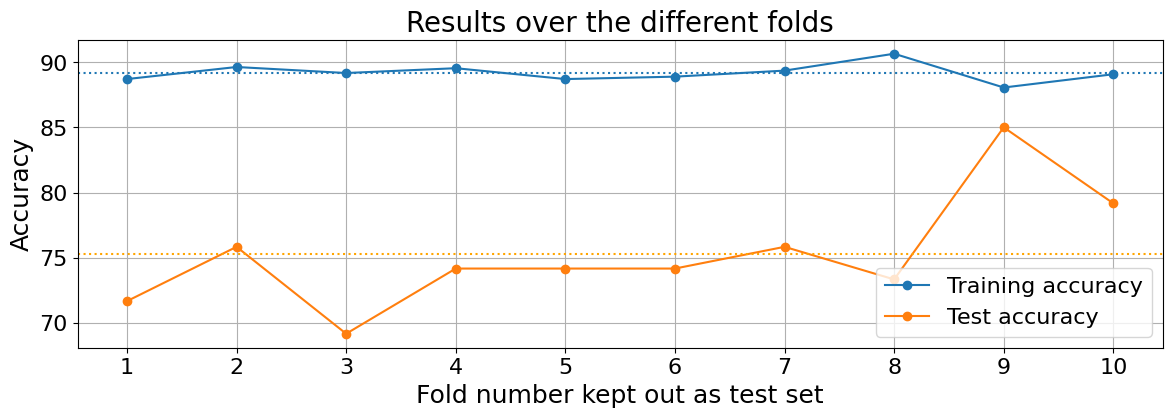

Minimum test accuracy:  0.69
Maximum test accuracy:  0.85


In [9]:
folds = np.arange(1, 11)
plt.figure(figsize=(14, 4))
plt.plot(folds, [elem * 100 for elem in training_accuracy_scores], 'o-', label="Training accuracy")
plt.axhline(y=np.average([elem * 100 for elem in training_accuracy_scores]), linestyle=':')
plt.plot(folds, [elem * 100 for elem in accuracy_scores], 'o-', label="Test accuracy")
plt.axhline(y=np.average([elem * 100 for elem in accuracy_scores]), linestyle=':', color="orange")

# Set x-axis ticks
plt.xticks(folds)

plt.xlabel('Fold number kept out as test set', fontsize=18)
plt.ylabel('Accuracy', fontsize=18) # Average Validation Accuracies\n over the 9 Training folds
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title('Results over the different folds', fontsize=20)
plt.legend(fontsize=16, loc="lower right")
plt.grid(True)
plt.show()

print("Minimum test accuracy: ", round(min(accuracy_scores), 2))
print("Maximum test accuracy: ", round(max(accuracy_scores), 2))

In [10]:
# display(metadata_with_classification_result[metadata_with_classification_result["ID"]=="A0047"])


def summary_metadata(metadata):
    """
    Look into the correct and wrongly classified people with regards to the metadata and creates a summary. 
    """
    

    correct_metadata = metadata[metadata['Correctly classified'] == True]
    wrong_metadata = metadata[metadata['Correctly classified'] == False] 
                
    correct_pd = correct_metadata[correct_metadata['Group'] == class_labels["PD"]]
    correct_hc = correct_metadata[correct_metadata['Group'] == class_labels["HC"]]
    
    avg_metadata = pd.DataFrame()
    avg_metadata.at["Correct classified", "amount PD"] = len(correct_pd)
    avg_metadata.at["Correct classified", "amount HC"] = len(correct_hc)
    
    avg_metadata.at["Correct classified", "amount female"] = len(correct_metadata[correct_metadata['SEX'] == "F"])
    avg_metadata.at["Correct classified", "amount male"] = len(correct_metadata[correct_metadata['SEX'] == "M"])
    
    avg_metadata.at["Correct classified", "avg AGE"] = np.average(correct_metadata['AGE'])
    avg_metadata.at["Correct classified", "avg AGE PD"] = np.average(correct_pd['AGE'])
    avg_metadata.at["Correct classified", "avg AGE HC"] = np.average(correct_hc['AGE'])
    avg_metadata.at["Correct classified", "avg UPDRS"] = np.average(correct_pd['UPDRS'])
    avg_metadata.at["Correct classified", "avg UPDRS-speech"] = np.average(correct_pd['UPDRS-speech'])
    avg_metadata.at["Correct classified", "avg H/Y"] = np.average(correct_pd['H/Y'])
    avg_metadata.at["Correct classified", "avg time after diagnosis"] = np.average(correct_pd['time after diagnosis'])
    avg_metadata.at["Correct classified", "Distance to decition boarder"] = np.average(np.abs(correct_pd['Distance to decition boarder']))
    
    wrong_pd = wrong_metadata[wrong_metadata['Group'] == class_labels["PD"]]
    wrong_hc = wrong_metadata[wrong_metadata['Group'] == class_labels["HC"]]
    
    avg_metadata.at["Wrong classified", "amount PD"] = len(wrong_pd)
    avg_metadata.at["Wrong classified", "amount HC"] = len(wrong_hc)
    
    avg_metadata.at["Wrong classified", "amount female"] = len(wrong_metadata[wrong_metadata['SEX'] == "F"])
    avg_metadata.at["Wrong classified", "amount male"] = len(wrong_metadata[wrong_metadata['SEX'] == "M"])

    avg_metadata.at["Wrong classified", "avg AGE"] = np.average(wrong_metadata['AGE'])
    avg_metadata.at["Wrong classified", "avg AGE PD"] = np.average(wrong_pd['AGE'])
    avg_metadata.at["Wrong classified", "avg AGE HC"] = np.average(wrong_hc['AGE'])
    avg_metadata.at["Wrong classified", "avg UPDRS"] = np.average(wrong_pd['UPDRS'])
    avg_metadata.at["Wrong classified", "avg UPDRS-speech"] = np.average(wrong_pd['UPDRS-speech'])
    avg_metadata.at["Wrong classified", "avg H/Y"] = np.average(wrong_pd['H/Y'])
    avg_metadata.at["Wrong classified", "avg time after diagnosis"] = np.average(wrong_pd['time after diagnosis'])
    avg_metadata.at["Wrong classified", 'Distance to decition boarder'] = np.average(np.abs(wrong_pd['Distance to decition boarder']))
    
    print("Average Metadata:")
    display(avg_metadata)

summary_metadata(metadata_with_classification_result)



Average Metadata:


,amount PD,amount HC,amount female,amount male,avg AGE,avg AGE PD,avg AGE HC,avg UPDRS,avg UPDRS-speech,avg H/Y,avg time after diagnosis,Distance to decition boarder
Correct classified,448.0,455.0,436.0,467.0,61.0,61.0,60.0,39.892857,1.412946,2.244420,11.266295,1.240268
Wrong classified,152.0,145.0,164.0,133.0,60.0,58.0,63.0,31.078947,1.125000,2.029605,11.154605,0.709605


In [11]:

def evaluate_ID(metadata, fold = True):
    """
    Look into the correct and wrongly classified people with regards to the ID. 

    Args:
        metadata (list): list of metadata also containing information about if the sample was correctly or wrongly classified. 
        fold (bool, default = True): fold indicates if the evaluation is done on folds, or on the whole data. 
    """
    
    ids = metadata["ID"].unique()
    
    num_utterances_per_person = len(metadata[metadata['ID'] == ids[0]])
    
    id_info = pd.DataFrame()
    id_info['ID'] = ids
    
    for i, id in enumerate(ids):
        id_data = metadata[metadata['ID'] == id]
        corr = len(id_data[id_data['Correctly classified'] == True])
        wrong = len(id_data[id_data['Correctly classified'] == False])
        
        id_info.at[i, "Number of correctly classified"] = corr
        id_info.at[i, "Number of wrongly classified"] = wrong

    all_metadata = add_columns_to_dataframe(id_info.copy(), metadata, ["SEX", "AGE", "UPDRS", "UPDRS-speech", "H/Y", "time after diagnosis", "Group", "Fold"])
    
    id_info.at["Average in fold:", "ID"] = ""
    id_info.at["Average in fold:", "Number of correctly classified"] = np.mean(id_info["Number of correctly classified"])
    id_info.at["Average in fold:", "Number of wrongly classified"] = np.mean(id_info["Number of wrongly classified"])
    
    # display(id_info)
    display(all_metadata)
    
    if fold:
        plot_bar(list(all_metadata["ID"]), list(all_metadata["Number of correctly classified"]), max = num_utterances_per_person, title="Number of correctly classified \n utterances from each ID", xlabel="ID", ylabel="Number of correctly classified utterances", fold=fold)
    else: 
        pd_metadata = all_metadata[all_metadata['Group'] == class_labels["PD"]]
        hc_metadata = all_metadata[all_metadata['Group'] == class_labels["HC"]]
        plot_bar(list(pd_metadata["ID"]), list(pd_metadata["Number of correctly classified"]), max = num_utterances_per_person, title="Number of correctly classified PD \n utterances from each ID", xlabel="ID", ylabel="Number of correctly classified utterances", fold=fold)
        plot_bar(list(hc_metadata["ID"]), list(hc_metadata["Number of correctly classified"]), max = num_utterances_per_person, title="Number of correctly classified HC \n utterances from each ID", xlabel="ID", ylabel="Number of correctly classified utterances", fold=fold)
    
    return all_metadata

# metadata_for_each_id = evaluate_ID(metadata_with_classification_result, fold = False)

# Evaluate each fold seperate: 
if False:  # Change to true if wanted to run. 
    for fold in metadata_with_classification_result["Fold"].unique():
        fold_data = metadata_with_classification_result[metadata_with_classification_result["Fold"]==fold]
        _ = evaluate_ID(fold_data, fold = True)


##  ROC, Threshold, distance to boarder and probabilities

In [12]:
# Can also use these values from the functions: 
roc_auc, distance_to_boarder_correct, distance_to_boarder_wrong, TN, TP, FN, FP, best_threshold_test_set = calculate_classification_detailes_from_cross_fold(metadata_with_classification_result)

print("Conf matrix values: ", TN, TP, FN, FP)

print(f"Number of correct classified {TN + TP}, Number of wrongly classified {FN + FP}")

print(f"Average distance to boarder from correctly classified samples: {distance_to_boarder_correct}")
print(f"Average distance to boarder from wrongly classified samples: {distance_to_boarder_wrong}")

avg_distance_to_boarder_all= round(np.mean(np.abs(metadata_with_classification_result['Distance to decition boarder'])), 2)
print(f"Average distance to boarder from all classified samples: {avg_distance_to_boarder_all}")

print(f"ROC AUC value: {roc_auc}")
print(f"Best threshold for test set:  {best_threshold_test_set}")


Conf matrix values:  455 448 152 145
Number of correct classified 903, Number of wrongly classified 297
Average distance to boarder from correctly classified samples: 1.23
Average distance to boarder from wrongly classified samples: 0.69
Average distance to boarder from all classified samples: 1.1
ROC AUC value: 0.83
Best threshold for test set:  -0.33


Note that the best threshold values are calculated on a combination of all the test set from the cross validation, and is therefore probably not the best for the model in total (but overfitted for the test set it is good)


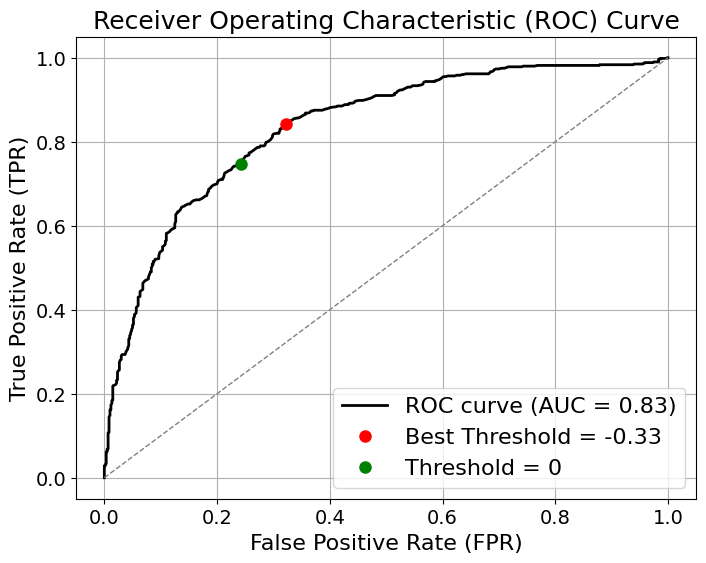

In [20]:


# Plotting ROC curve: 

def plot_ROC(dist_to_boarder, true, original_threshold=0):
    """
    Plots ROC curve based on distance to decision border and true valus. 
    """
    fpr, tpr, thresholds = metrics.roc_curve(true, dist_to_boarder)
    roc_auc = metrics.auc(fpr, tpr)  
    
    # Plot the ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='black', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')

    # Mark the best threshold in the plot 
    best_threshold_idx = np.argmax(tpr - fpr)  # Choosen based on Youden's J statistic --> Maximising TPR - FPR
    best_threshold = thresholds[best_threshold_idx]
    plt.plot(fpr[best_threshold_idx], tpr[best_threshold_idx], marker='o', markersize=8, color='red', label=f'Best Threshold = {best_threshold:.2f}', linestyle='None')

    # Mark the threshold at 0 in the plot
    threshold_0_idx = np.argmin(np.abs(thresholds - original_threshold)) # Gives the index for the threshold at 0.5. 
    plt.plot(fpr[threshold_0_idx], tpr[threshold_0_idx], marker='o', markersize=8, color='green', label=f'Threshold = {original_threshold}', linestyle='None')

    # Add labels and legend
    plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')  # Random guess line
    plt.xlabel('False Positive Rate (FPR)', fontsize = 16)
    plt.ylabel('True Positive Rate (TPR)', fontsize = 16)
    plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize = 18)
    plt.xticks(fontsize = 14)
    plt.yticks(fontsize = 14)
    plt.legend(loc='lower right', fontsize=16)
    plt.grid(True)
    plt.show()
    return best_threshold

print("Note that the best threshold values are calculated on a combination of all the test set from the cross validation, and is therefore probably not the best for the model in total (but overfitted for the test set it is good)")

best_threshold_dist_boarder = plot_ROC(np.array(metadata_with_classification_result["Distance to decition boarder"]), np.array(metadata_with_classification_result["True class"]), original_threshold=0)


## Evaluating metadata

In [14]:
def find_classification_result_for_each_id(metadata):
    
    """
    Takes inn the metadata with the classification results and add a column indicating the accuracy of correctly classified samples for each person. 
    """
    
    ids = metadata["ID"].unique()
        
    id_info = pd.DataFrame()
    id_info['ID'] = ids
    
    for i, id in enumerate(ids):
        id_data = metadata[metadata['ID'] == id]
        corr = len(id_data[id_data['Correctly classified'] == True])
        wrong = len(id_data[id_data['Correctly classified'] == False])
        
        id_info.at[i, "Number of correctly classified"] = corr
        id_info.at[i, "Number of wrongly classified"] = wrong
        id_info.at[i, "Accuracy corr"] = round(corr/(corr + wrong)*100, 2)

    id_classification_results = add_columns_to_dataframe(id_info.copy(), metadata, ["SEX", "AGE", "UPDRS", "UPDRS-speech", "H/Y", "time after diagnosis", "Group", "Fold"])

    return id_classification_results

metadata_for_each_id = find_classification_result_for_each_id(metadata_with_classification_result)

display(metadata_for_each_id)



,ID,Number of correctly classified,Number of wrongly classified,Accuracy corr,SEX,AGE,UPDRS,UPDRS-speech,H/Y,time after diagnosis,Group,Fold
0,AC0006,7.0,5.0,58.33,F,65,NaN,NaN,NaN,NaN,0,0
1,AC0024,9.0,3.0,75.00,F,61,NaN,NaN,NaN,NaN,0,0
2,AC0037,5.0,7.0,41.67,M,76,NaN,NaN,NaN,NaN,0,0
3,AC0043,8.0,4.0,66.67,M,68,NaN,NaN,NaN,NaN,0,0
4,AC0045,12.0,0.0,100.00,M,67,NaN,NaN,NaN,NaN,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
95,A0022,12.0,0.0,100.00,M,57,20.0,0.0,2.0,0.4,1,9
96,A0030,12.0,0.0,100.00,M,75,75.0,3.0,3.0,16.0,1,9
97,A0048,6.0,6.0,50.00,F,49,53.0,3.0,2.0,16.0,1,9
98,A0052,11.0,1.0,91.67,F,70,23.0,1.0,2.0,12.0,1,9


 --------------- 
Age distributions:
PD
  Age Group  mean_accuracy  count
0     30-54      52.272727     11
1     55-59      79.860000     12
2     60-64      82.144286      7
3     65-69      82.576364     11
4     70-90      79.630000      9
HC
  Age Group  mean_accuracy  count
0     30-54      89.815556      9
1     55-59      68.750000      8
2     60-64      77.941765     17
3     65-69      76.667000     10
4     70-90      56.946667      6
 --------------- 
Extent of the disease distributions:
UPDRS-speech
  UPDRS-speech  mean_accuracy  count
0            0      51.190000      7
1            1      76.811739     23
2      2 & 2.5      82.291875     16
3            3      72.917500      4
4            4            NaN      0
5            5            NaN      0
HY
       H/Y  mean_accuracy  count
0        0            NaN      0
1        1      51.388333      6
2  2 & 2.5      78.333333     30
3        3      75.000769     13
4        4     100.000000      1
5        5           

/tmp/ipykernel_2248667/550099748.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  updrs_speech['UPDRS-speech'] = pd.cut(updrs_speech["UPDRS-speech"], bins=[0, 1, 2, 3, 4, 5, 6], labels=updrs_labels, right=False)
/tmp/ipykernel_2248667/550099748.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hy["H/Y"] = pd.cut(hy["H/Y"], bins=[0, 1, 2, 3, 4, 5, 6], labels=updrs_labels, right=False)
/tmp/ipykernel_2248667/550099748.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

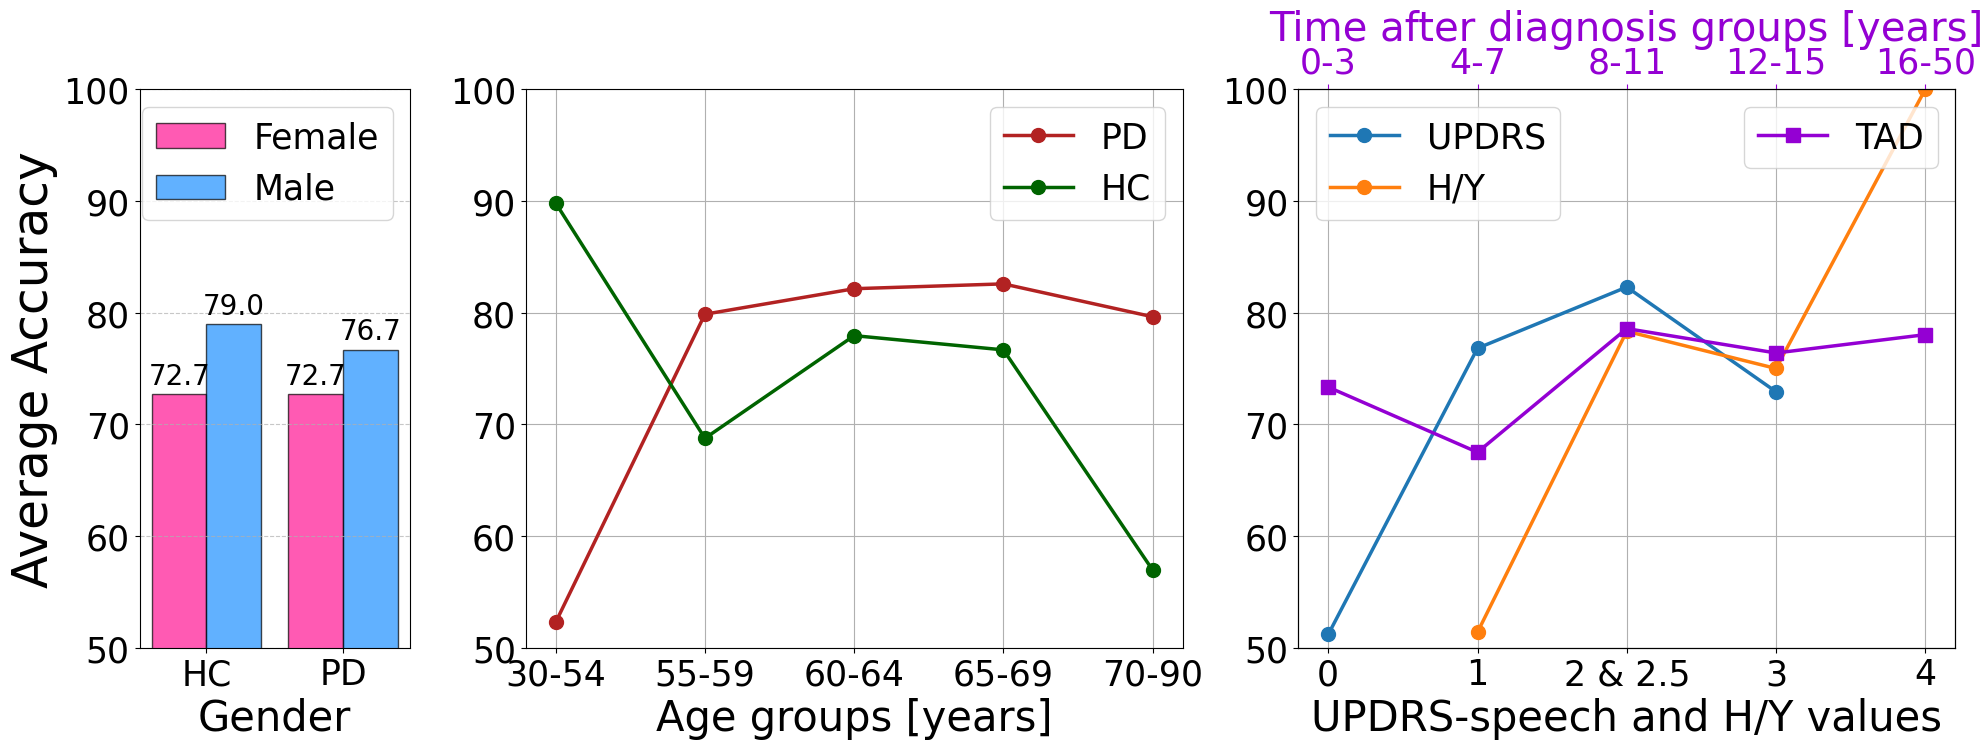

In [15]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

def evaluate_gender(metadata, ax): 
    """
    Creates bar chart that evaluates classification accuracy for the different gender groups. 
    """

    pd = metadata[metadata['Group'] == 1]
    hc = metadata[metadata['Group'] == 0]
        
    acc_women_hc = round(np.average(hc[hc['SEX'] == 'F']["Accuracy corr"]), 1)
    acc_men_hc = round(np.average(hc[hc['SEX'] == 'M']["Accuracy corr"]), 1)
    
    acc_women_pd = round(np.average(pd[pd['SEX'] == 'F']["Accuracy corr"]), 1)
    acc_men_pd = round(np.average(pd[pd['SEX'] == 'M']["Accuracy corr"]), 1)
        
    classification_results = ['HC', 'PD']
    
    bar_width = 0.4
    indices = np.arange(len(classification_results))

    rects1 = ax.bar(indices + 0 * bar_width, [acc_women_hc, acc_women_pd], width=bar_width, color=female_color, label='Female', alpha=0.7, edgecolor='black')
    autolabel(rects1, ax, size=20)
    rects2 = ax.bar(indices + 1 * bar_width, [acc_men_hc, acc_men_pd], width=bar_width, color=male_color, label='Male', alpha=0.7, edgecolor='black')
    autolabel(rects2, ax, size=20)

    ax.set_xticks(indices + bar_width / 2, classification_results)
    ax.set_xticklabels(classification_results, fontsize=25)
    ax.tick_params(axis='y', labelsize=25)
    ax.set_ylim(50, 100)
    ax.set_xlabel('Gender', fontsize=30)
    ax.set_ylabel('Average Accuracy', fontsize=35)
    ax.legend(fontsize=25)
    ax.grid(axis='y', linestyle='--', alpha=0.7)

def age_distribution_correctly_classified(id_classification_results, ax):
    """
    Creates plot that evaluates classification accuracy for the different age groups. 
    """
    pd_metadata = id_classification_results[id_classification_results['Group'] == class_labels["PD"]]
    hc_metadata = id_classification_results[id_classification_results['Group'] == class_labels["HC"]]
    elem = "AGE"
    
    bins = [30, 55, 60, 65, 70, 90]
    labels = ['30-54', '55-59', '60-64', '65-69', '70-90']
        
    pd_metadata = pd_metadata[[elem, "Accuracy corr"]]
    hc_metadata = hc_metadata[[elem, "Accuracy corr"]]

    pd_metadata['Age Group'] = pd.cut(pd_metadata['AGE'], bins=bins, labels=labels, right=False)
    hc_metadata['Age Group'] = pd.cut(hc_metadata['AGE'], bins=bins, labels=labels, right=False)

    grouped_pd = pd_metadata.groupby('Age Group', observed=False).agg(
        mean_accuracy=('Accuracy corr', 'mean'),
        count=('AGE', 'count')
    ).reset_index()

    grouped_hc = hc_metadata.groupby('Age Group', observed=False).agg(
        mean_accuracy=('Accuracy corr', 'mean'),
        count=('AGE', 'count')
    ).reset_index()
    
    print(" --------------- ")
    print("Age distributions:")
    print("PD")
    print(grouped_pd)
    print("HC")
    print(grouped_hc)

    ax.plot(grouped_pd['Age Group'], grouped_pd['mean_accuracy'], color=PD_color, marker='o', label='PD', markersize=10, linewidth=2.5)    
    ax.plot(grouped_hc['Age Group'], grouped_hc['mean_accuracy'], color=HC_color, marker='o', label='HC', markersize=10, linewidth=2.5)
    ax.set_xlabel('Age groups [years]', fontsize=30)
    ax.tick_params(axis='x', labelsize=25)
    ax.tick_params(axis='y', labelsize=25)
    ax.set_ylim(50, 100)
    ax.legend(fontsize=25)
    ax.grid(True)

def updrs_hy_age_distribution(id_classification_results, ax1, ax2):
    """
    Creates plot that evaluates classification accuracy for the different metadata groups that shows extent of the disease. 
    """
    pd_metadata = id_classification_results[id_classification_results['Group'] == class_labels["PD"]]
    
    updrs_labels = ["0", "1", "2 & 2.5", "3", "4", "5"]
    updrs_speech = pd_metadata[["UPDRS-speech", "Accuracy corr"]]
    hy = pd_metadata[["H/Y", "Accuracy corr"]]
    
    updrs_speech['UPDRS-speech'] = pd.cut(updrs_speech["UPDRS-speech"], bins=[0, 1, 2, 3, 4, 5, 6], labels=updrs_labels, right=False)
    grouped_updrs = updrs_speech.groupby('UPDRS-speech', observed=False).agg(
        mean_accuracy=('Accuracy corr', 'mean'),
        count=('UPDRS-speech', 'count')
    ).reset_index()
    
    hy["H/Y"] = pd.cut(hy["H/Y"], bins=[0, 1, 2, 3, 4, 5, 6], labels=updrs_labels, right=False)
    grouped_hy = hy.groupby('H/Y', observed=False).agg(
        mean_accuracy=('Accuracy corr', 'mean'),
        count=("H/Y", 'count')
    ).reset_index()

    tad_bins = [0, 4, 8, 12, 16, 50]
    tad_labels = ["0-3", "4-7", "8-11", "12-15", "16-50"]
    tad = pd_metadata[["time after diagnosis", "Accuracy corr"]]
    tad["time after diagnosis"] = pd.cut(tad["time after diagnosis"], bins=tad_bins, labels=tad_labels, right=False)
    grouped_tad = tad.groupby("time after diagnosis", observed=False).agg(
        mean_accuracy=('Accuracy corr', 'mean'),
        count=("time after diagnosis", 'count')
    ).reset_index()
    
    
    print(" --------------- ")
    print("Extent of the disease distributions:")
    print("UPDRS-speech")
    print(grouped_updrs)
    print("HY")
    print(grouped_hy)
    print("TAD")
    print(grouped_tad)

    ax1.plot(updrs_labels, grouped_updrs['mean_accuracy'], marker='o', label='UPDRS', markersize=10, linewidth=2.5)
    ax1.plot(updrs_labels, grouped_hy['mean_accuracy'], marker='o', label='H/Y', markersize=10, linewidth=2.5)
    ax1.set_xlabel('UPDRS-speech and H/Y values', fontsize=30)
    ax1.tick_params(axis='x', labelsize=25)
    ax1.tick_params(axis='y', labelsize=25)
    ax1.grid(True)
    ax1.set_ylim(50, 100)
    ax1.legend(loc='upper left', fontsize=25)

    ax2.set_xlabel('Time after diagnosis groups [years]', fontsize=29, color='darkviolet')
    ax2.tick_params(axis='x', labelsize=25, colors='darkviolet')
    ax2.plot(tad_labels, grouped_tad['mean_accuracy'], marker='s', label='TAD', color='darkviolet', markersize=10, linewidth=2.5)
    ax2.legend(loc='upper right', fontsize=25)

fig = plt.figure(figsize=(20, 8))

gs = GridSpec(1, 5, figure=fig) # Create a GridSpec to have more control over subplot placement

ax1 = fig.add_subplot(gs[0, 0])  # Smaller plot for gender
ax2 = fig.add_subplot(gs[0, 1:3])  # Larger plot for age distribution
ax3 = fig.add_subplot(gs[0, 3:5])  # Larger plot for UPDRS/HY

# Plot the data
evaluate_gender(metadata_for_each_id, ax1)
age_distribution_correctly_classified(metadata_for_each_id, ax2)
updrs_hy_age_distribution(metadata_for_each_id, ax3, ax3.twiny())

# Adjust the layout to create more space between the subplots
plt.subplots_adjust(wspace=0.4)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


# Analyse top and bottom persons and their metadata: 

In [16]:
# Analyse the best and worst samples: 

n = 20  # specifies how many of the best and worst rows with regards to how many times a person is classified correct we want to get out. 

p = metadata_for_each_id[metadata_for_each_id['Group'] == class_labels["PD"]]
h = metadata_for_each_id[metadata_for_each_id['Group'] == class_labels["HC"]]

parkinsons_top = p.nlargest(n, "Number of correctly classified")
parkinsons_bottom = p.nsmallest(n, "Number of correctly classified")

healthy_top = h.nlargest(n, "Number of correctly classified")
healthy_bottom = h.nsmallest(n, "Number of correctly classified")


avg_metadata = pd.DataFrame()

avg_metadata.at["Best", "amount PD"] = len(parkinsons_top)
avg_metadata.at["Best", "amount female"] = len(parkinsons_top[parkinsons_top['SEX'] == "F"])
avg_metadata.at["Best", "amount male"] = len(parkinsons_top[parkinsons_top['SEX'] == "M"])
avg_metadata.at["Best", "avg AGE PD"] = np.average(parkinsons_top['AGE'])
avg_metadata.at["Best", "avg UPDRS"] = np.average(parkinsons_top['UPDRS'])
avg_metadata.at["Best", "avg UPDRS-speech"] = np.average(parkinsons_top['UPDRS-speech'])
avg_metadata.at["Best", "avg H/Y"] = np.average(parkinsons_top['H/Y'])
avg_metadata.at["Best", "avg time after diagnosis"] = np.average(parkinsons_top['time after diagnosis'])

avg_metadata.at["Worst", "amount PD"] = len(parkinsons_bottom)
avg_metadata.at["Worst", "amount female"] = len(parkinsons_bottom[parkinsons_bottom['SEX'] == "F"])
avg_metadata.at["Worst", "amount male"] = len(parkinsons_bottom[parkinsons_bottom['SEX'] == "M"])
avg_metadata.at["Worst", "avg AGE PD"] = np.average(parkinsons_bottom['AGE'])
avg_metadata.at["Worst", "avg UPDRS"] = np.average(parkinsons_bottom['UPDRS'])
avg_metadata.at["Worst", "avg UPDRS-speech"] = np.average(parkinsons_bottom['UPDRS-speech'])
avg_metadata.at["Worst", "avg H/Y"] = np.average(parkinsons_bottom['H/Y'])
avg_metadata.at["Worst", "avg time after diagnosis"] = np.average(parkinsons_bottom['time after diagnosis'])

print("Average Metadata for PD:")
display(avg_metadata)



# HEALTHY: 

avg_metadata = pd.DataFrame()
avg_metadata.at["Best", "amount HC"] = len(healthy_top)

avg_metadata.at["Best", "amount female"] = len(healthy_top[healthy_top['SEX'] == "F"])
avg_metadata.at["Best", "amount male"] = len(healthy_top[healthy_top['SEX'] == "M"])
avg_metadata.at["Best", "avg AGE HC"] = np.average(healthy_top['AGE'])

avg_metadata.at["Worst", "amount HC"] = len(healthy_bottom)
avg_metadata.at["Worst", "amount female"] = len(healthy_bottom[healthy_bottom['SEX'] == "F"])
avg_metadata.at["Worst", "amount male"] = len(healthy_bottom[healthy_bottom['SEX'] == "M"])
avg_metadata.at["Worst", "avg AGE HC"] = np.average(healthy_bottom['AGE'])

print("Average Metadata for HC:")
display(avg_metadata)


Average Metadata for PD:


,amount PD,amount female,amount male,avg AGE PD,avg UPDRS,avg UPDRS-speech,avg H/Y,avg time after diagnosis
Best,20.0,7.0,13.0,63.0,45.15,1.55,2.375,9.72
Worst,20.0,11.0,9.0,57.0,32.95,1.20,2.150,12.95


Average Metadata for HC:


,amount HC,amount female,amount male,avg AGE HC
Best,20.0,10.0,10.0,61.0
Worst,20.0,12.0,8.0,63.0
